**Ref**

- [2019 ML month 2nd baseline 커널](https://www.kaggle.com/code/kcs93023/2019-ml-month-2nd-baseline/notebook)
- [Geo Data EDA & Feature Engineering](https://github.com/tmheo/2019-2nd-ML-month-with-KaKR-Solution/blob/master/notebook/geo-data-eda-and-feature-engineering.ipynb)
- [11th Solution: Public 98316, Private 99336](https://www.kaggle.com/code/tmheo74/11th-solution-public-98316-private-99336/notebook)
- [Default EDA - Stacking Introduction](https://www.kaggle.com/code/yeonmin/default-eda-stacking-introduction/notebook)




## Default import

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno
import xgboost as xgb
import lightgbm as lgb
import gc

import matplotlib.pyplot as plt
import seaborn as sns

import time
from datetime import datetime, timedelta,date
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, Ridge
from sklearn.cluster import KMeans
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV



In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Data Setting

In [3]:
train_data_path = join('./data', 'train.csv')
test_data_path = join('./data', 'test.csv')

df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(test_data_path)


print('train data dim : {}'.format(df_train.shape))
print('sub data dim : {}'.format(df_test.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [4]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## EDA & Processing

### EDA

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

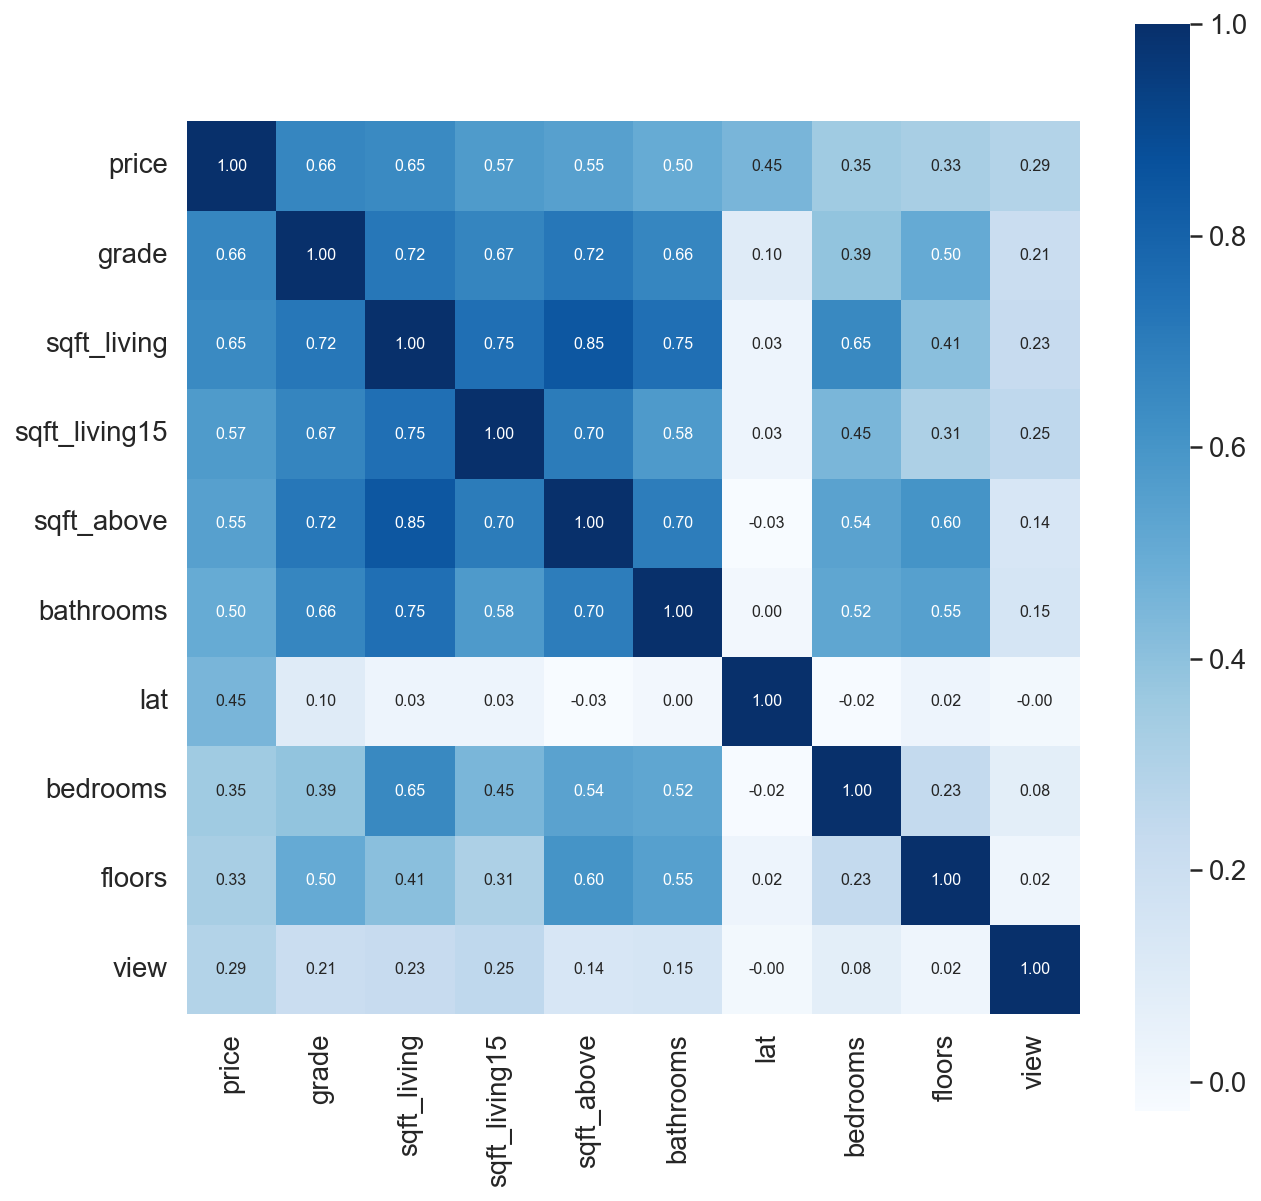

In [5]:
# 상관관계 분석

import scipy as sp

cor_abs = abs(df_train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(df_train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values, cmap = "Blues")

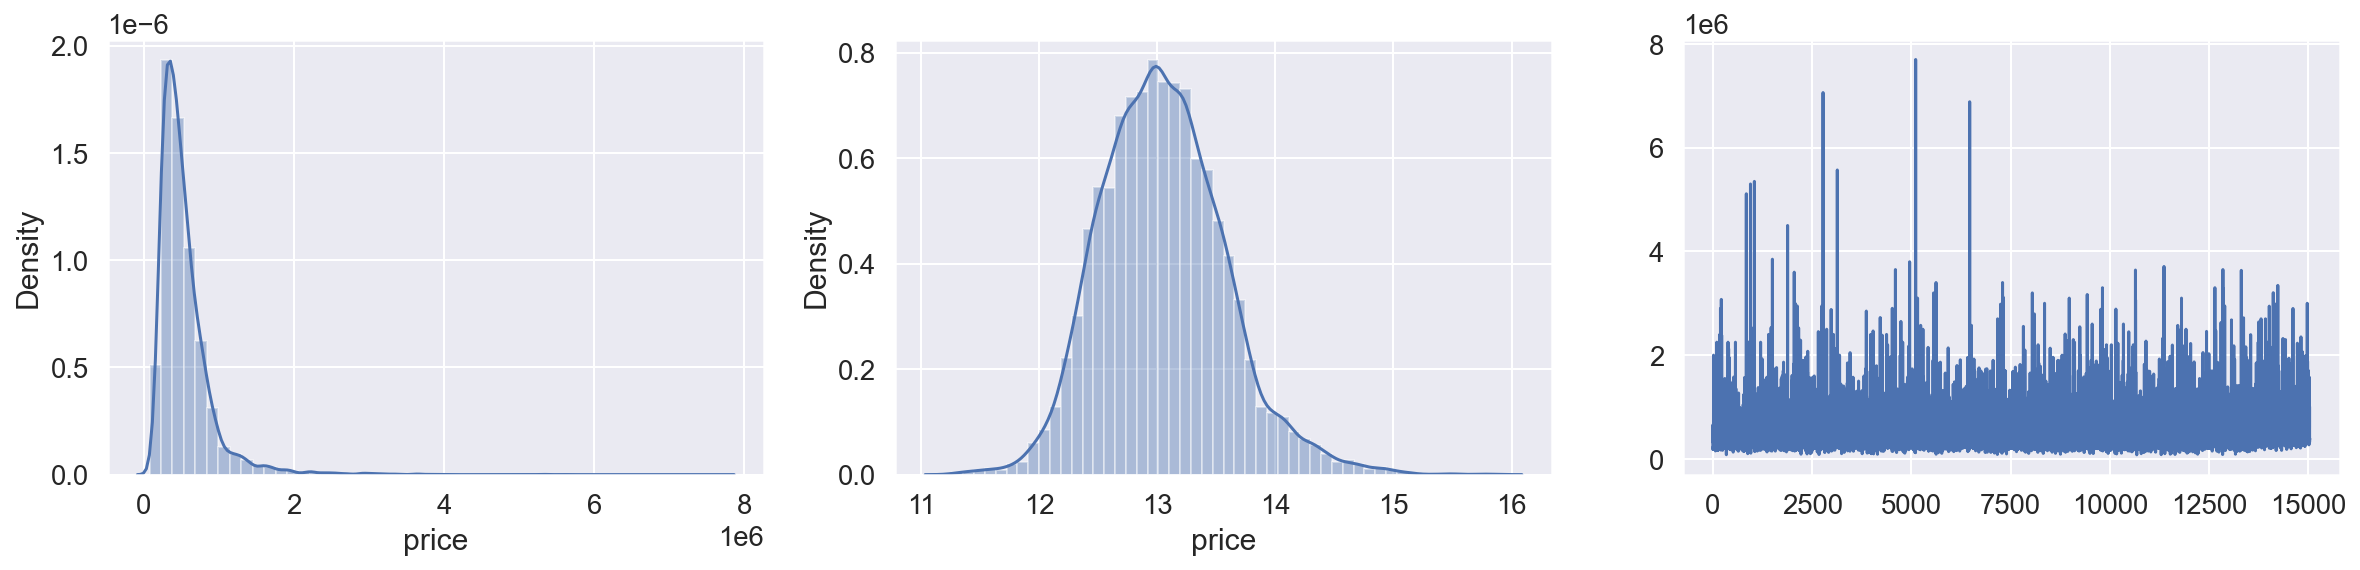

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(20,4))
sns.distplot(df_train['price'], ax=ax[0])
sns.distplot(np.log1p(df_train['price']), ax=ax[1])
df_train['price'].plot(ax=ax[2])
plt.show()

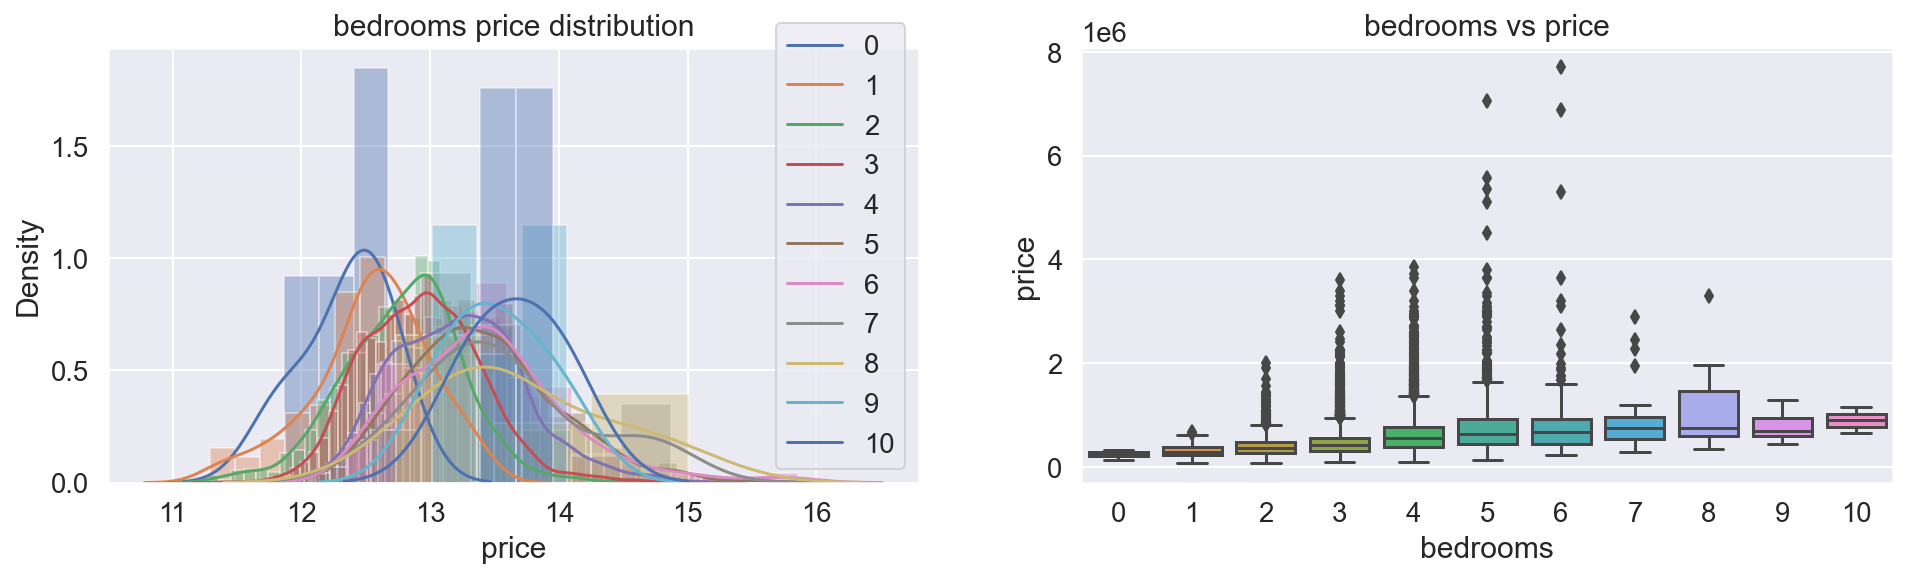

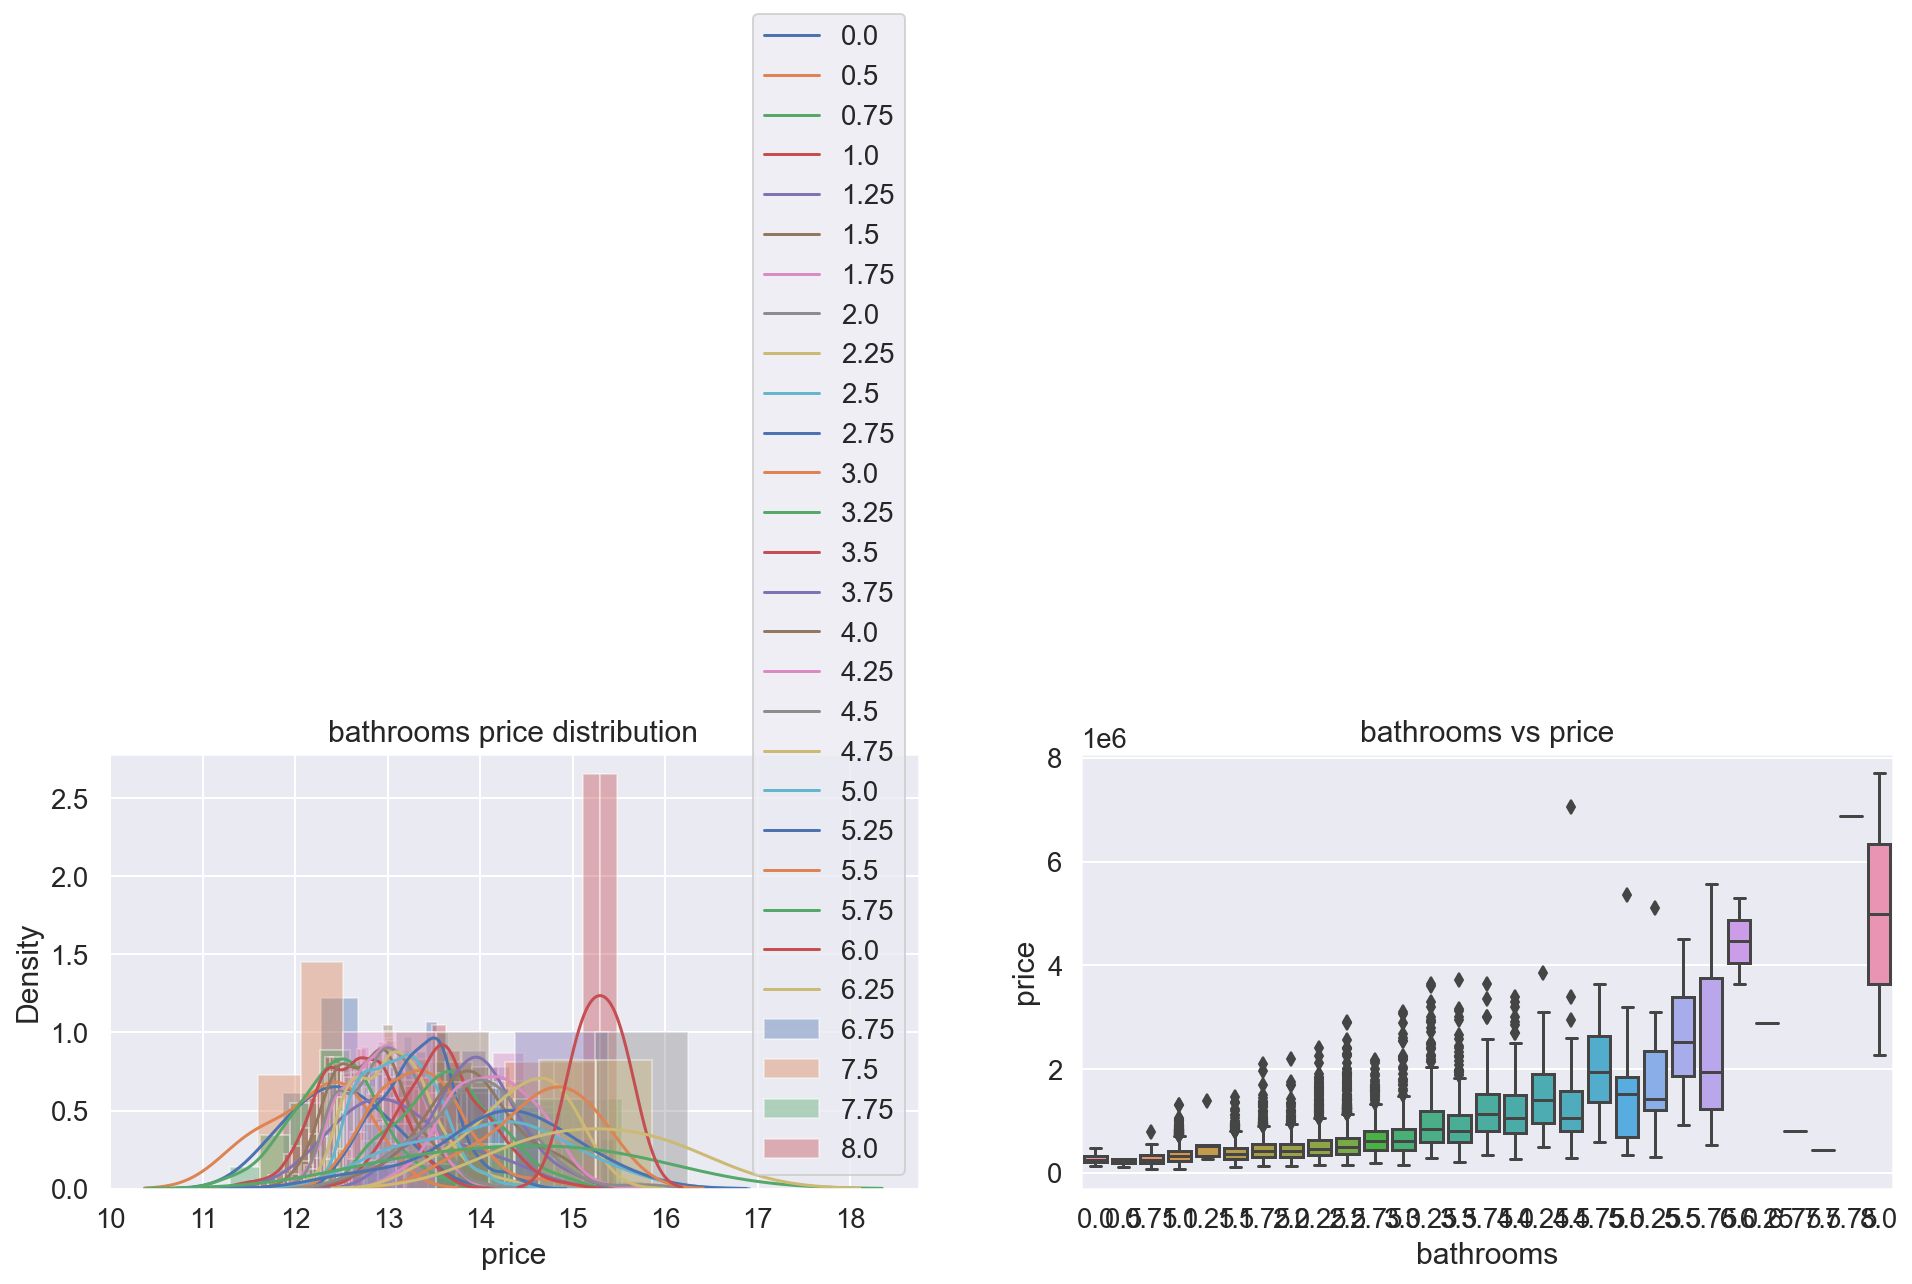

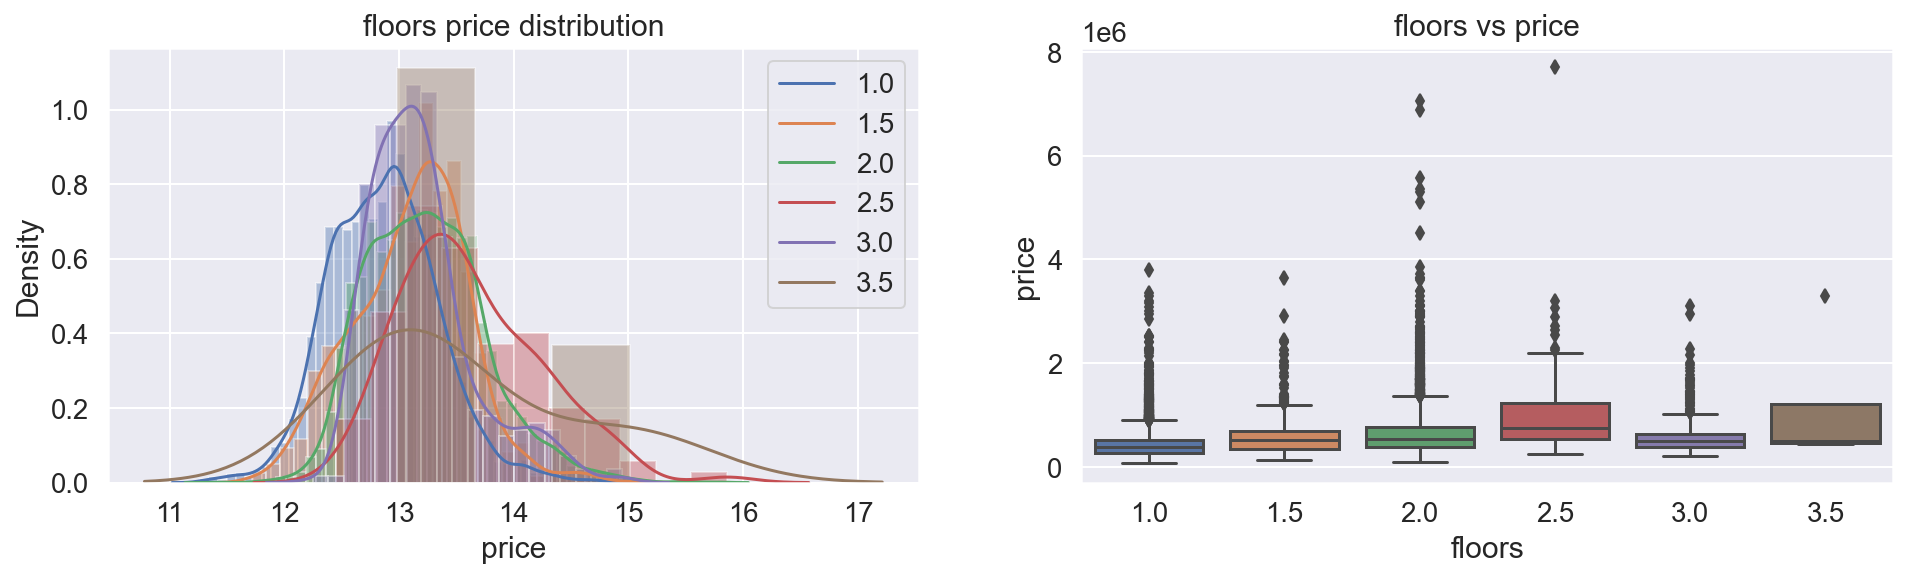

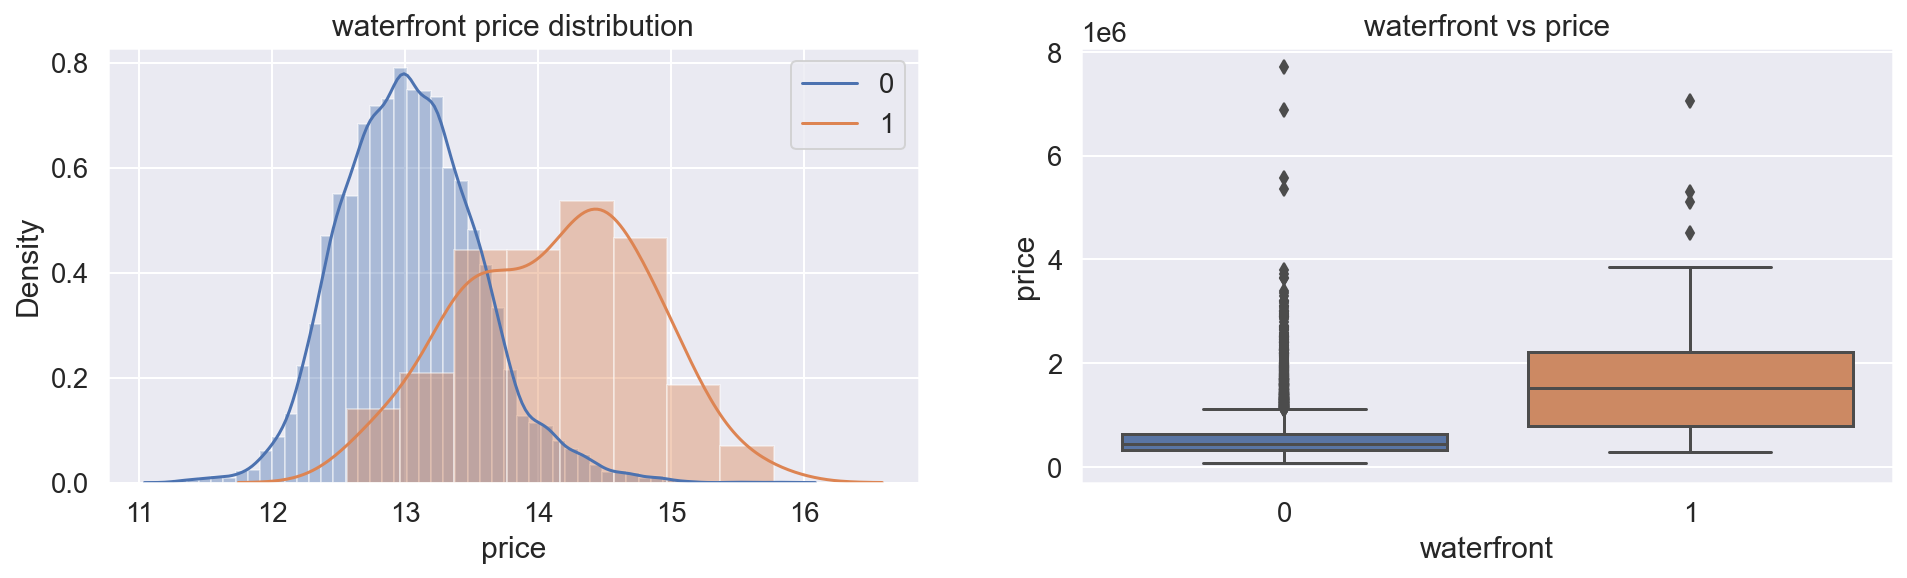

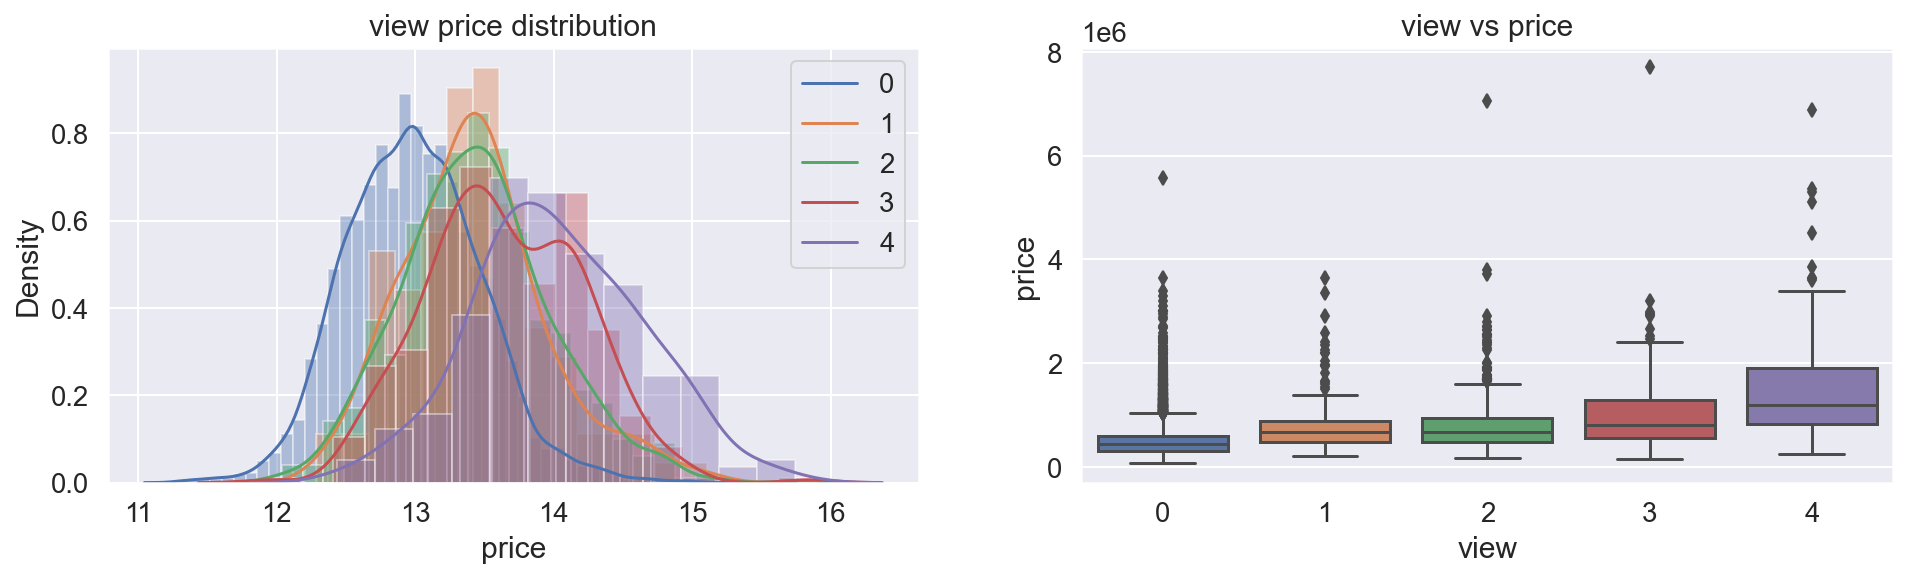

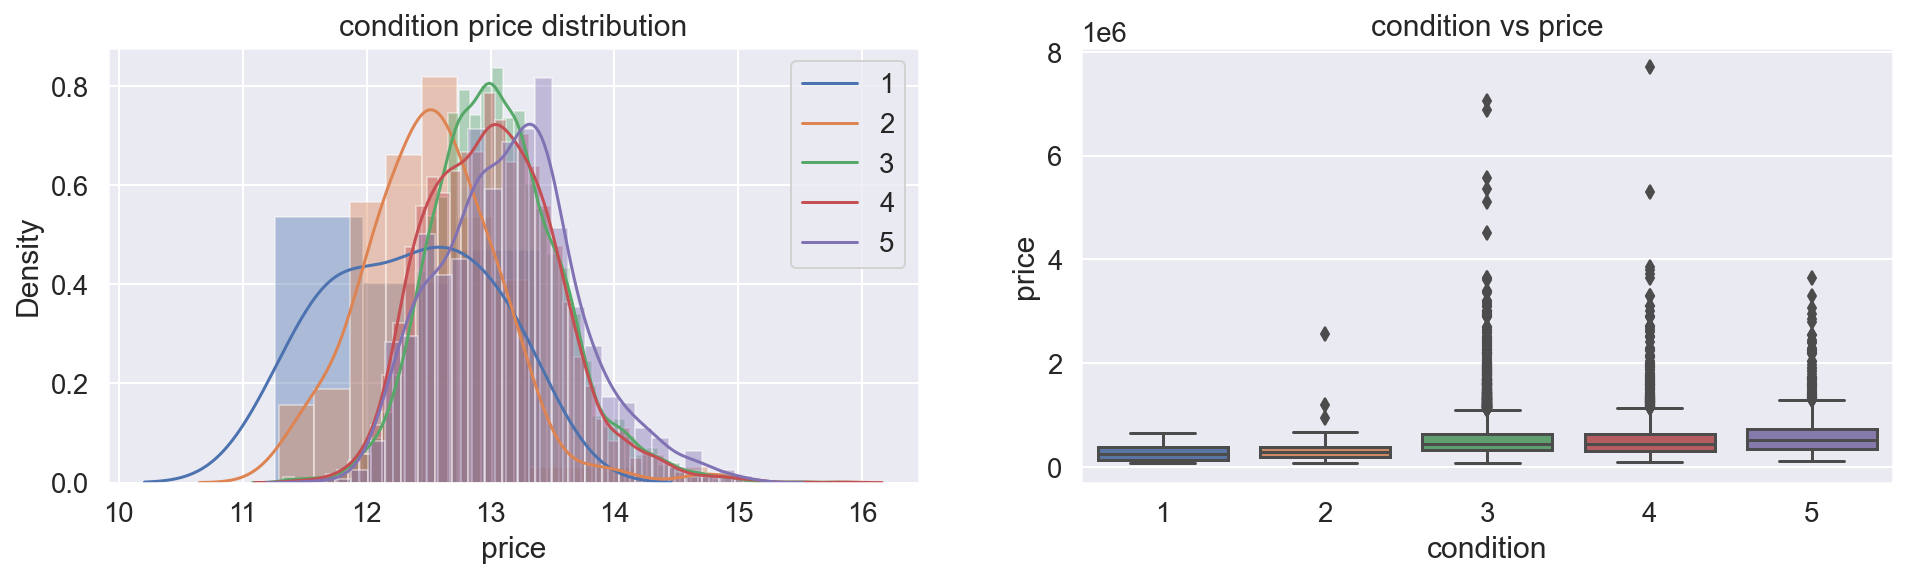

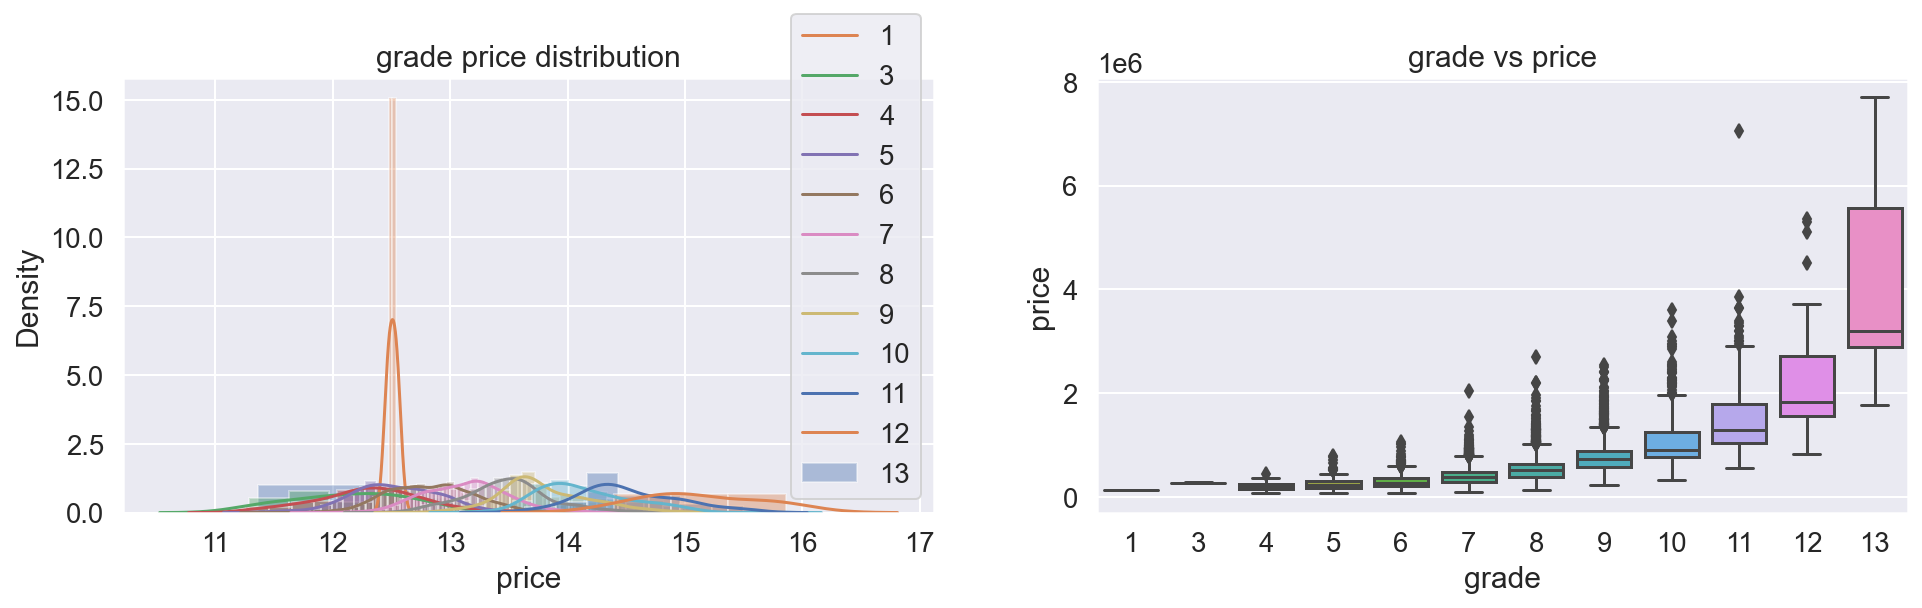

In [7]:
## 이산 값들에 대한 분포 확인

def category_feature_distribution(train, col, target='price'):
    # 각 항목의 가격 분포를 확인하기 위한 함수
    fig, ax = plt.subplots(1, 2, figsize=(16,4))
    
    for c in sorted(train[col].unique()):
        # 각 칼럼의 유니크만 sort해서 c로 반복
        # ex)
        # df_train['bedrooms'].unique()
        # array([ 3,  2,  5,  4,  6,  1,  7,  9,  8,  0, 10])
        sns.distplot(np.log1p(train.loc[train[col]==c, target]), ax=ax[0])
        # log로 정규화 해서 train[col]과 target(price) 뽑기
    ax[0].legend(sorted(train[col].unique()))
    # 범례 : train[col]
    ax[0].set_title(f'{col} {target} distribution')
    # title : <col> price distribution

    sns.boxplot(x=col, y=target, data=df_train, ax=ax[1])
    ax[1].set_title(f'{col} vs {target}')
    # title : <col> vs Price
    
    plt.show()

for col in ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']:
    # 각각의 col price distribution & <col> vs price 뽑기
    category_feature_distribution(df_train, col)

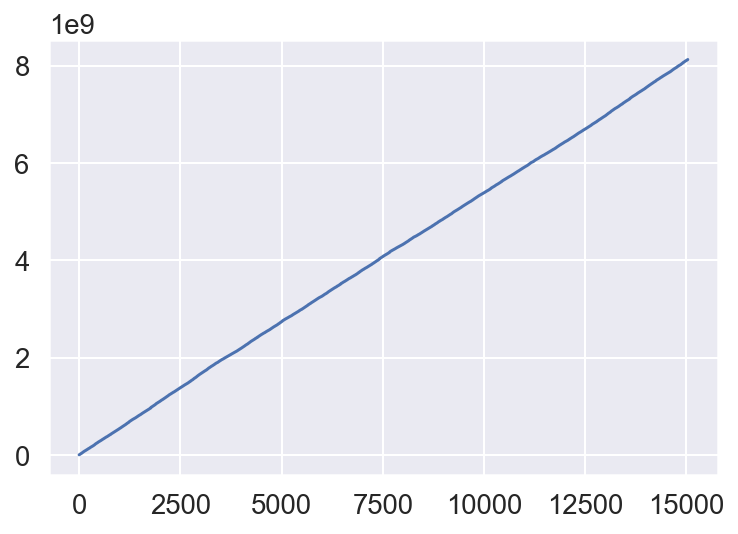

In [8]:
plt.plot(df_train.sort_values('date')['price'].cumsum().values)
# 여기서 찌끄러짐이 있었다면 시간 데이터가 제대로 안들어가 있음을 의미

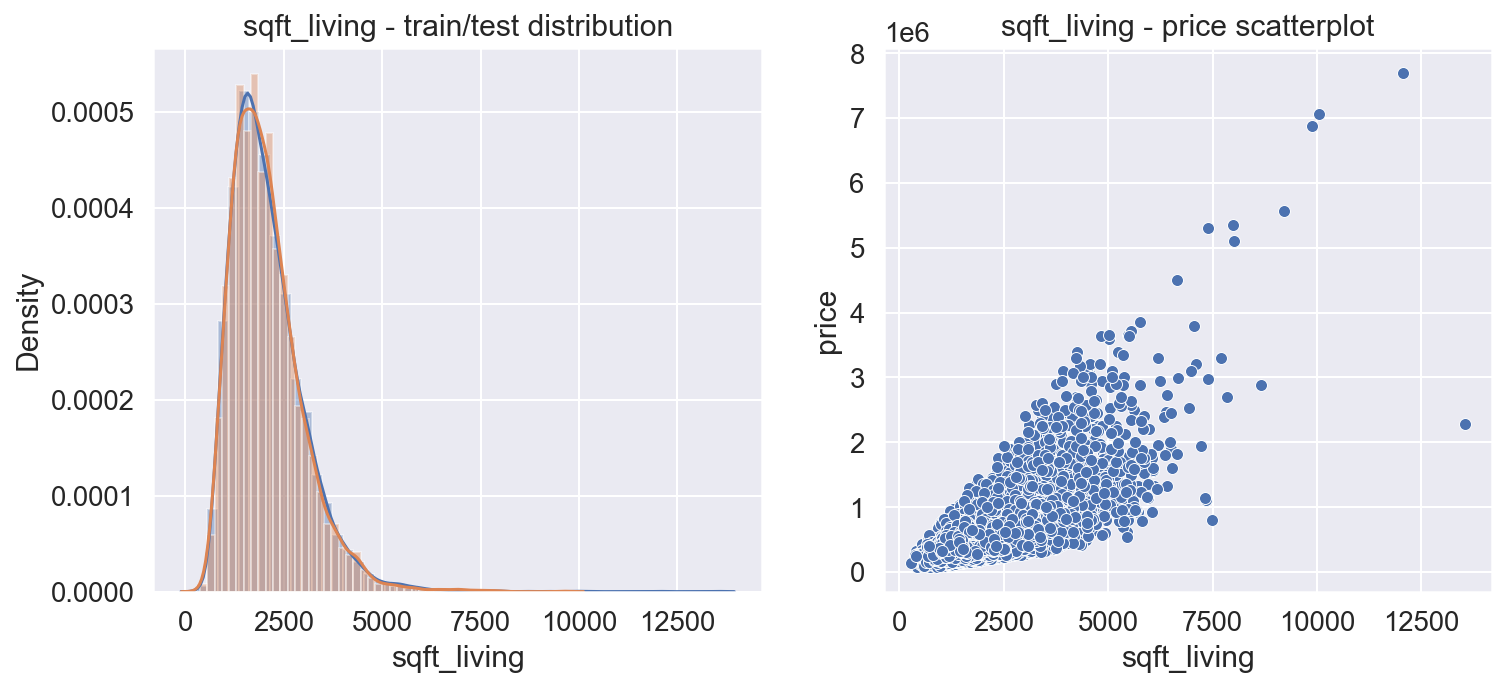

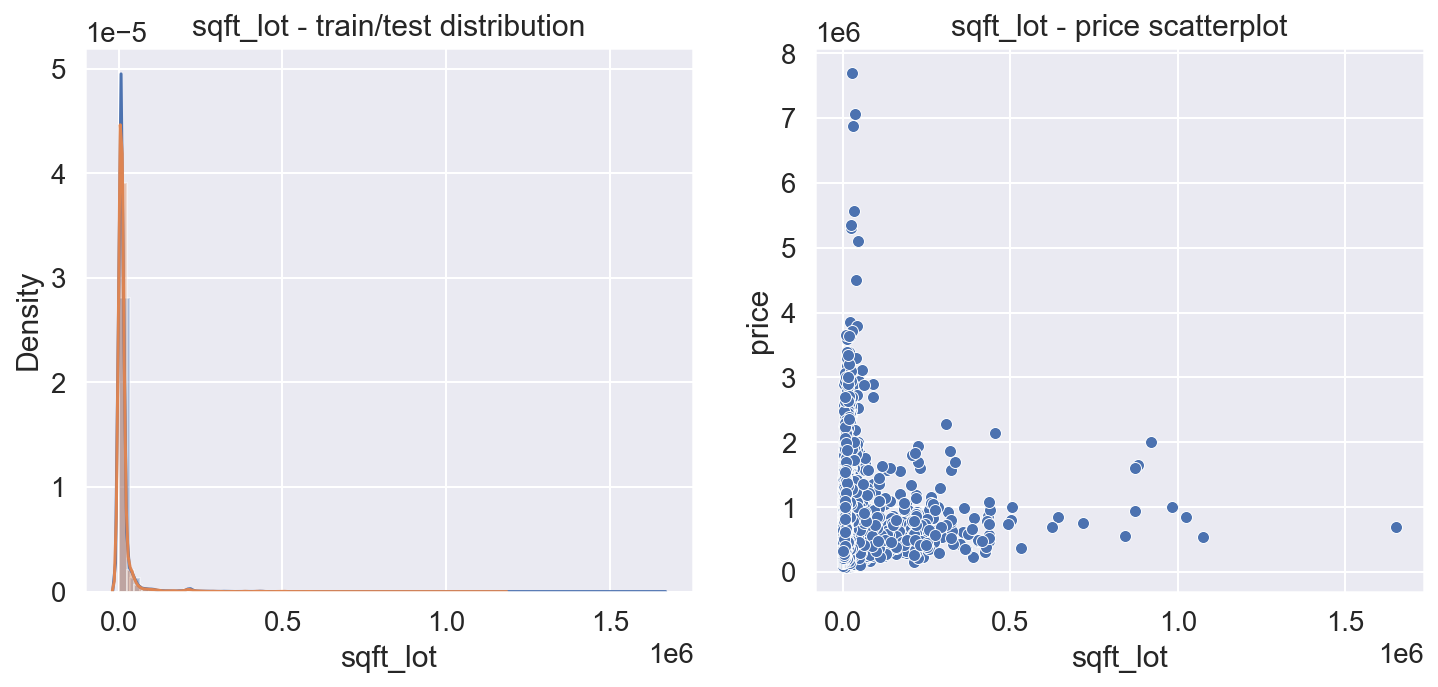

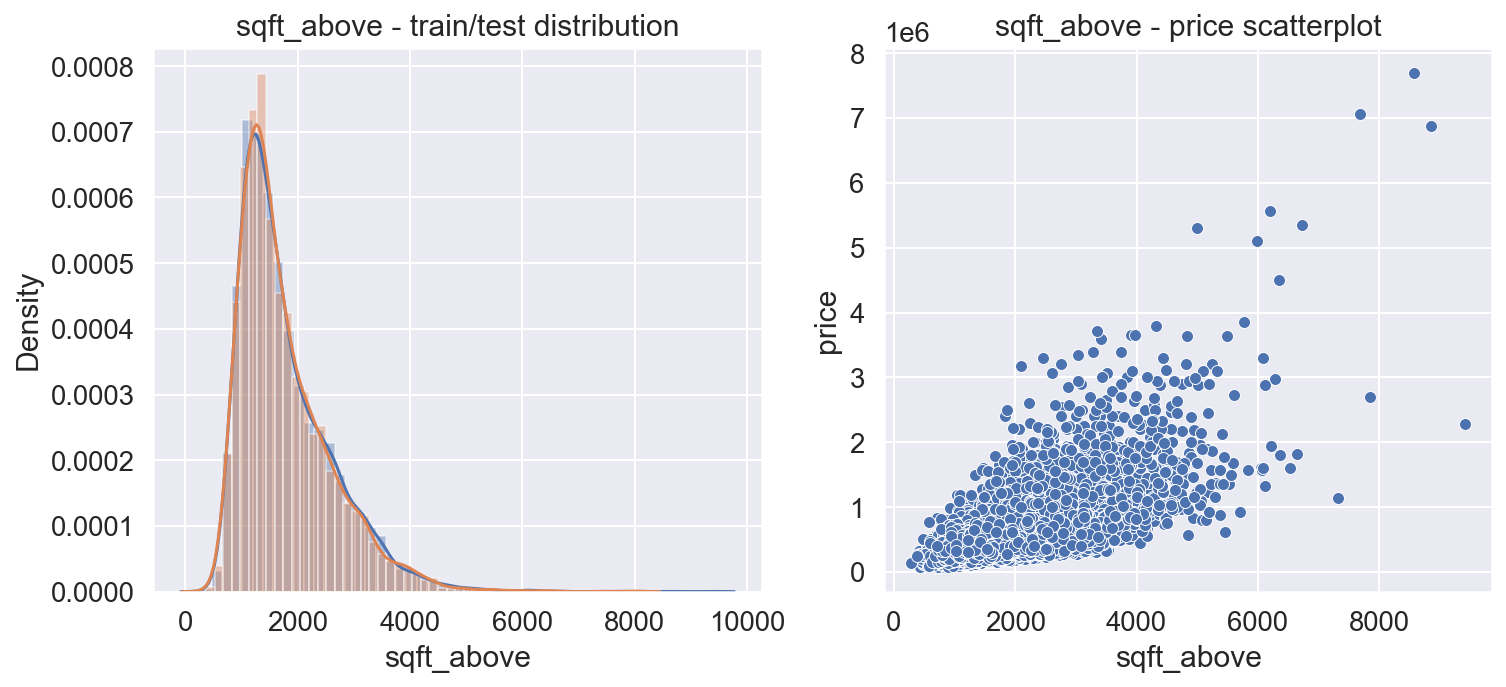

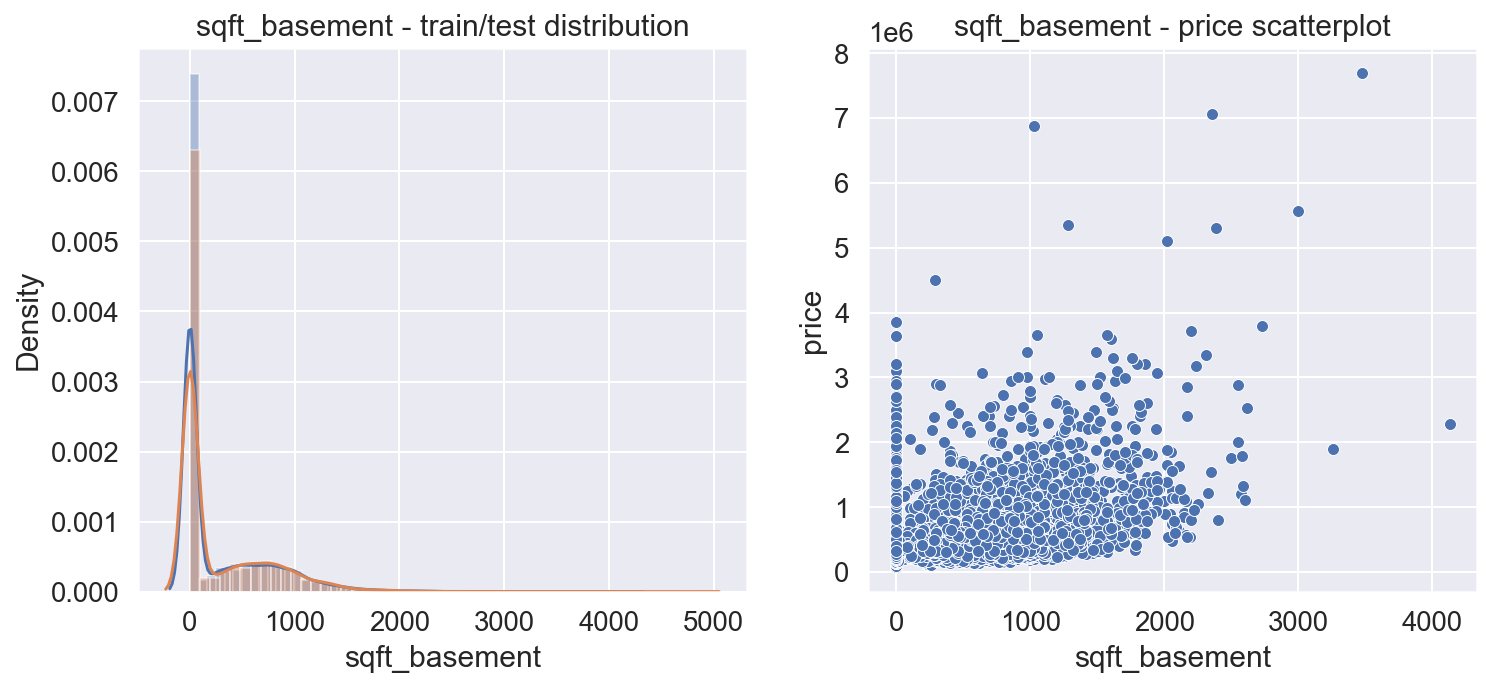

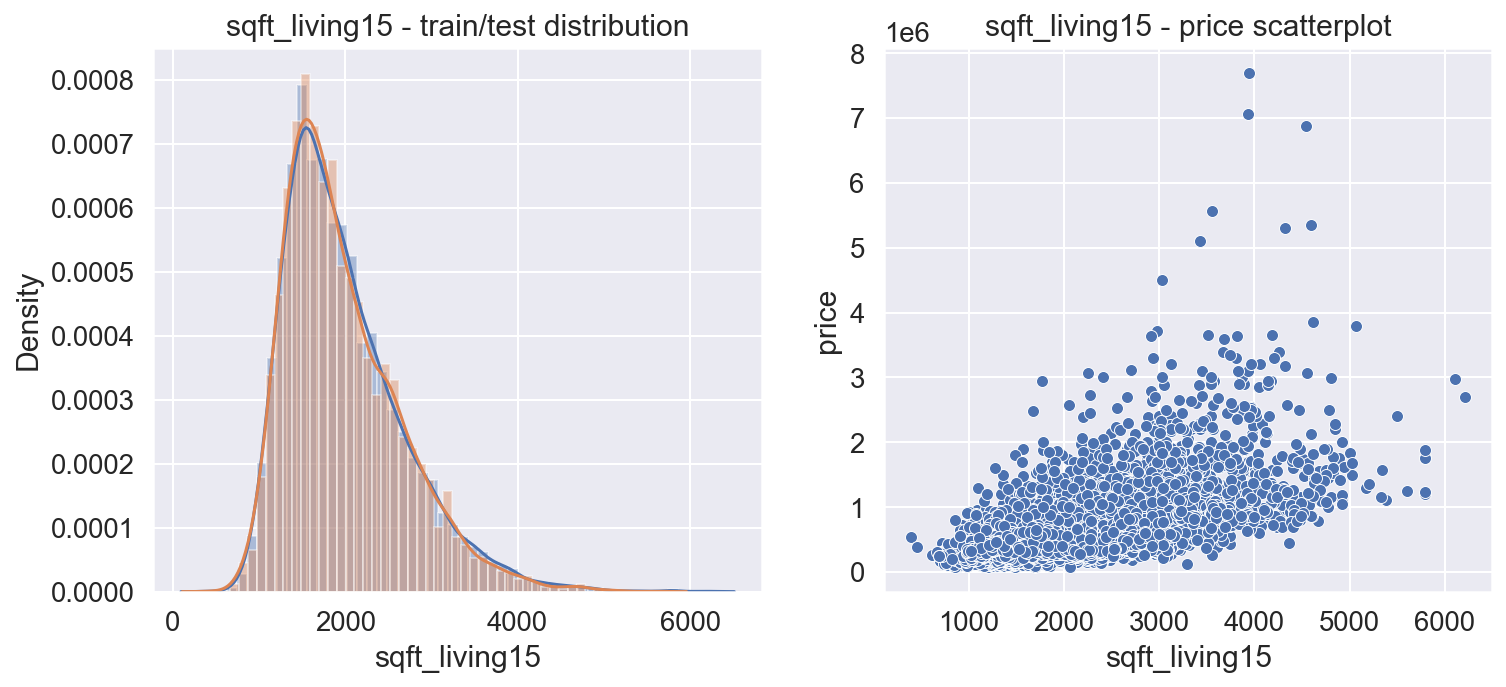

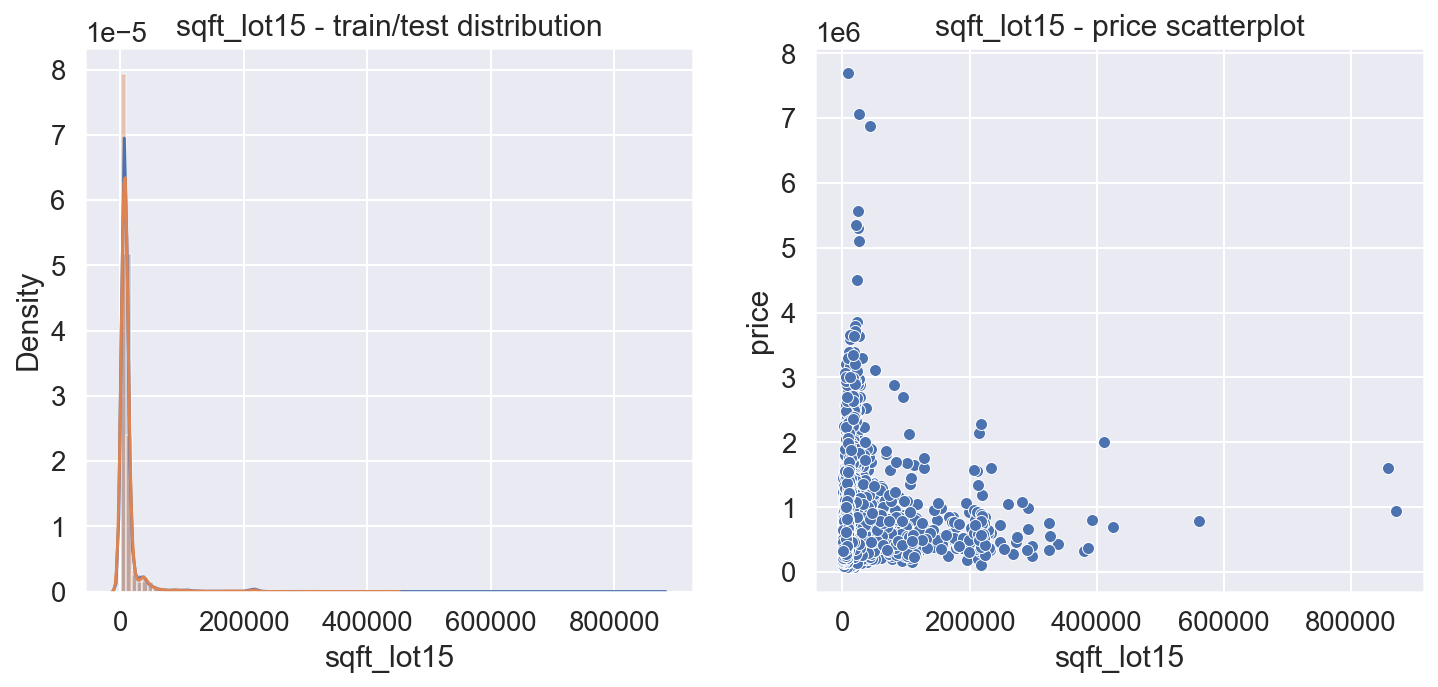

In [9]:
## 이산 값들에 대한 분포 확인


def continous_feature_distribution(train, test, col, target='price'):
    # target은 언제나 price
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    
    sns.distplot(train[col], ax=ax[0])
    sns.distplot(test[col], ax=ax[0])
    ax[0].set_title(f'{col} - train/test distribution')
    # 왼쪽 표의 이름 : <각 칼럼명> - train/test distribution

    sns.scatterplot(x=col, y=target, data=train, ax=ax[1])
    ax[1].set_title(f'{col} - {target} scatterplot')
    # 오른쪽 표의 이름 : <각 칼럼명> - price scatterplot

    plt.show()


area_feature = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']
for col in area_feature:
    continous_feature_distribution(df_train, df_test, col)

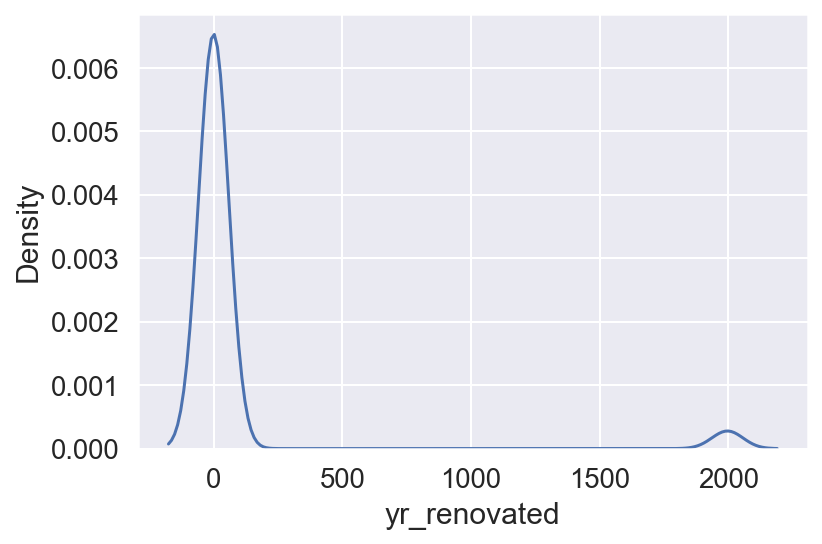

In [10]:
sns.kdeplot(df_train['yr_renovated'])
plt.show()

### Processing

In [11]:
# 10개 이상의 bedroom은 아웃라이어로 보고 드랍

df_train = df_train.loc[df_train['bedrooms']<10]

In [12]:
# baseline에 있는 processing _ log 씌워서 분포 이쁘게 해주깅

skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    df_train[c] = np.log1p(df_train[c].values)
    df_test[c] = np.log1p(df_test[c].values)

In [13]:
# 집을 재건축한 년도

for df in [df_train,df_test]:
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

In [14]:
# 새로운 feature 만들기


def feature_processing(df):
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    # 전체 방 수 = 침실 + 화장실

    df['grade_condition'] = df['grade'] * df['condition']
    # 등급_상태 = 집의 등급 * 집의 전반적인 상태

    df['sqft_total'] = df['sqft_living'] + df['sqft_lot']
    # 전체 면적
    # 피트 기준
    # 주거 공간 면적 + 부지 공간 면적

    df['sqft_total_size'] = df['sqft_living'] + df['sqft_lot'] + df['sqft_above'] + df['sqft_basement']
    # 전체 사이즈
    # 피트 기준
    # 주거 면적 + 부지 면적 + 지하실 제외(차고 등등 _ 이하 차고) + 지하실 포함

    df['sqft_total15'] = df['sqft_living15'] + df['sqft_lot15'] 
    # 15년 기준 전체 면적
    # 15년 기준 주거 면적 + 15년 기준 부지 면적

    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    # 재건축 _ 재건축을 안했다면 0, 했다면 지어진지 a년 뒤에 재건축
    # 재건축 년도 - 지어진 년도
    
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
    # 재건축 했다면 1, 안했다면 0
    
    df['roombybathroom'] = df['bedrooms'] / df['bathrooms']
    # 방마다 있는 화장실 수
    # 침실 / 화장실

    df['sqft_total_by_lot'] = (df['sqft_living'] + df['sqft_above'] + df['sqft_basement'])/df['sqft_lot']
    # 주거 면적 % 부지 면적
    # (주거 공간 + 차고 + 지하실) / 부지 면적

    qcut_count = 10
    # 10(피트)을 기준으로 공간 나누기 & int화
    df['qcut_long'] = pd.qcut(df['long'], qcut_count, labels=range(qcut_count))
    df['qcut_lat'] = pd.qcut(df['lat'], qcut_count, labels=range(qcut_count))
    df['qcut_long'] = df['qcut_long'].astype(int)
    df['qcut_lat'] = df['qcut_lat'].astype(int)

    df['date'] = pd.to_datetime(df['date'])
    df['yearmonth'] = df['date'].dt.year*100 + df['date'].dt.month
    df['date'] = df['date'].astype('int')
    return df


In [15]:
# 모든 데이터에 대해 processing 적용
all_df = pd.concat([df_train, df_test])
all_df = feature_processing(all_df)

In [16]:
# price가 비어있고 아니고를 기준으로 test, train 분리

df_test = all_df.loc[all_df['price'].isnull()]
df_train = all_df.loc[all_df['price'].notnull()]

In [17]:
df_train['roombybathroom']

0        3.000000
1        2.000000
2        1.500000
3        1.333333
4        2.000000
           ...   
15030    1.600000
15031    1.142857
15032    1.200000
15033    1.600000
15034    2.666667
Name: roombybathroom, Length: 15033, dtype: float64

In [18]:
def get_prefix(group_col, target_col, prefix=None):
    if isinstance(group_col, list) is True:
        # group_col이 list인지 확인.
        g = '_'.join(group_col)
        # True라면, g에
    else:
        g = group_col
    if isinstance(target_col, list) is True:
        t = '_'.join(target_col)
    else:
        t = target_col
    if prefix is not None:
        return prefix + '_' + g + '_' + t
    return g + '_' + t
    
def groupby_helper(df, group_col, target_col, agg_method, prefix_param=None):
    try:
        prefix = get_prefix(group_col, target_col, prefix_param)
        print(group_col, target_col, agg_method)
        group_df = df.groupby(group_col)[target_col].agg(agg_method)
        group_df.columns = ['{}_{}'.format(prefix, m) for m in agg_method]
    except BaseException as e:
        print(e)
    return group_df.reset_index()

In [19]:
group_df = groupby_helper(df_train, 'grade', 'price', ['mean'])
df_train = df_train.merge(group_df, on='grade', how='left')
df_test = df_test.merge(group_df, on='grade', how='left')

group_df = groupby_helper(df_train, 'bedrooms', 'price', ['mean'])
df_train = df_train.merge(group_df, on='bedrooms', how='left')
df_test = df_test.merge(group_df, on='bedrooms', how='left')

group_df = groupby_helper(df_train, 'bathrooms', 'price', ['mean'])
df_train = df_train.merge(group_df, on='bathrooms', how='left')
df_test = df_test.merge(group_df, on='bathrooms', how='left')

grade price ['mean']
bedrooms price ['mean']
bathrooms price ['mean']


['price' 'grade_price_mean' 'grade' 'sqft_living' 'sqft_living15'
 'sqft_above' 'bathrooms_price_mean' 'bathrooms' 'total_rooms'
 'grade_condition']


<AxesSubplot:>

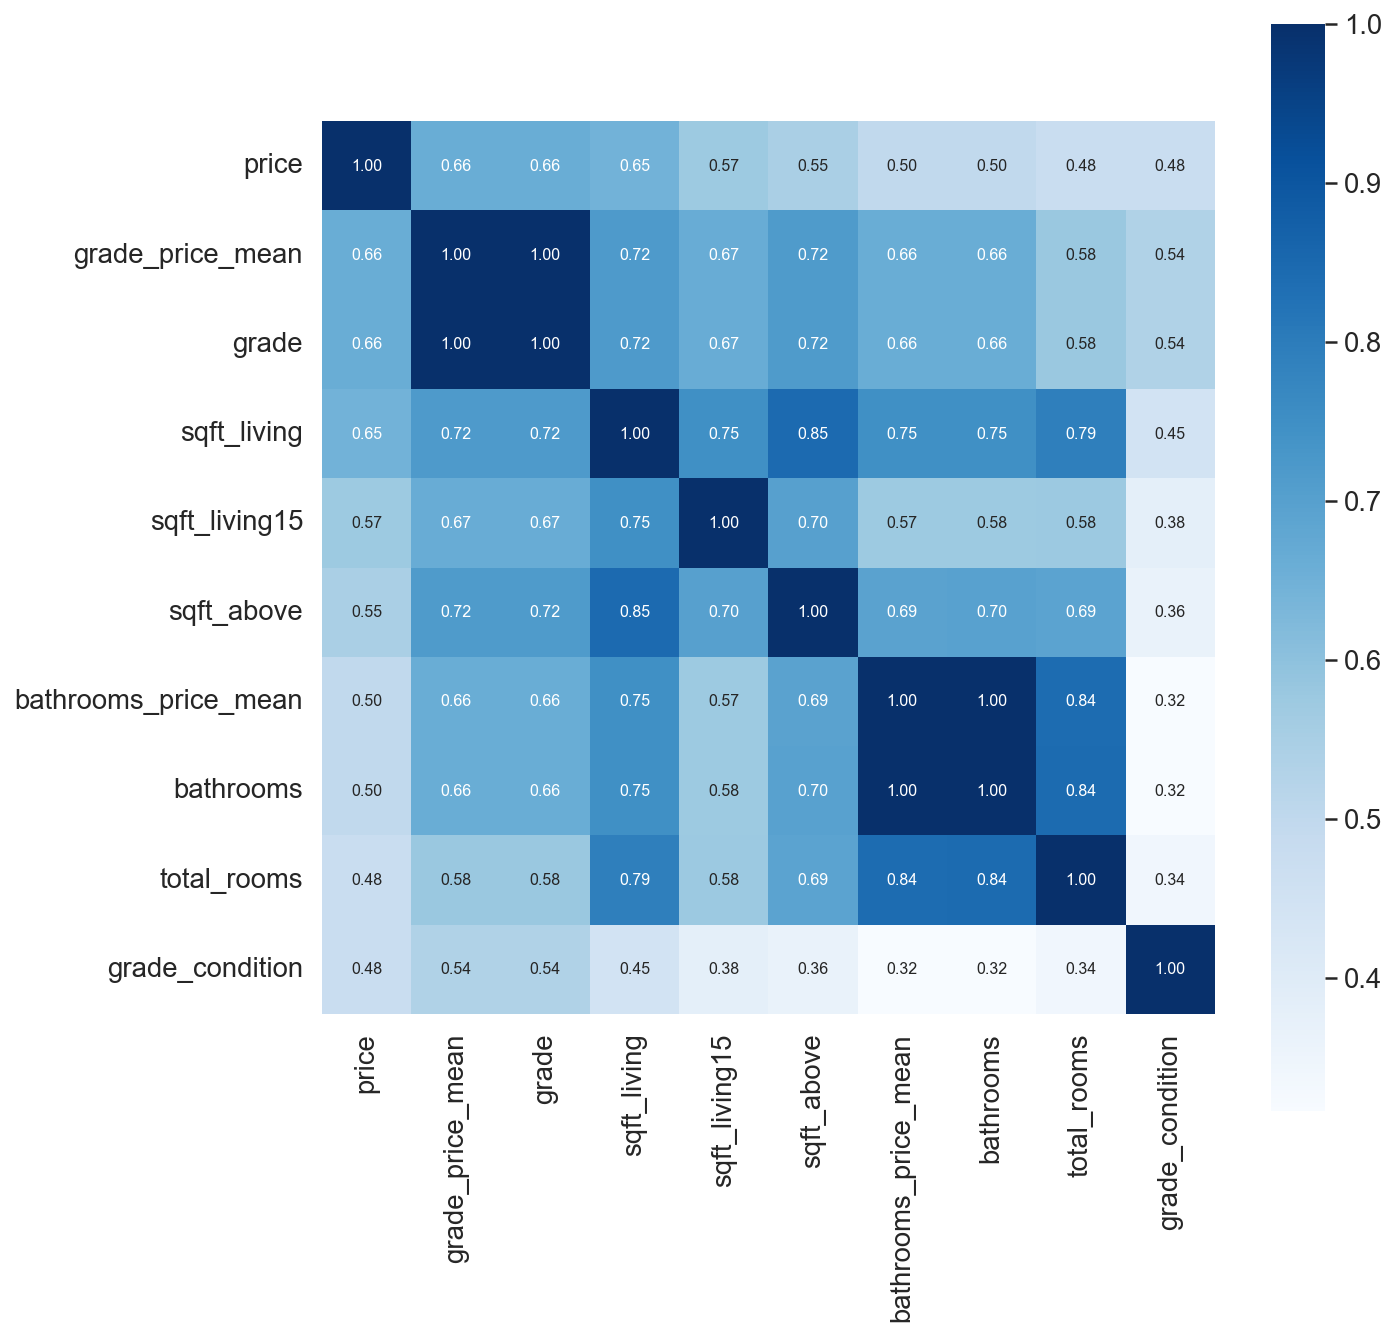

In [20]:
# 상관관계 다시 분석

cor_abs = abs(df_train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(df_train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)

plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values, cmap = "Blues")

## Modeling

In [21]:
train_columns = [col for col in df_train.columns if col not in ['id','price']]

x_train = df_train.copy()
y_train = np.log1p(df_train['price'])
del x_train['price']
x_train.loc[np.isinf(x_train['roombybathroom']),'roombybathroom'] = -1
# 추후 rb를 쓰기 위한


x_test = df_test.copy()
x_test.loc[np.isinf(x_test['roombybathroom']),'roombybathroom'] = -1
# 추후 rb를 쓰기 위한

In [22]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_true), np.expm1(y_pred)))

In [23]:
from functools import wraps
def time_decorator(func): 
    @wraps(func)
    def wrapper(*args, **kwargs):
        print("\nStartTime: ", datetime.now() + timedelta(hours=9))
        start_time = time.time()
        
        df = func(*args, **kwargs)
        
        print("EndTime: ", datetime.now() + timedelta(hours=9))  
        print("TotalTime: ", time.time() - start_time)
        return df
        
    return wrapper


def get_oof(clf, x_train, y_train, x_test, eval_func, **kwargs):
    nfolds = kwargs.get('NFOLDS', 5)
    kfold_shuffle = kwargs.get('kfold_shuffle', True)
    kfold_random_state = kwargs.get('kfold_random_state', 0)
    stratified_kfold_ytrain = kwargs.get('stratifed_kfold_y_value', None)
    ntrain = x_train.shape[0]
    ntest = x_test.shape[0]
    
    kf_split = None
    if stratified_kfold_ytrain is None:
        kf = KFold(n_splits=nfolds, shuffle=kfold_shuffle, random_state=kfold_random_state)
        kf_split = kf.split(x_train)
    else:
        kf = StratifiedKFold(n_splits=nfolds, shuffle=kfold_shuffle, random_state=kfold_random_state)
        kf_split = kf.split(x_train, stratified_kfold_ytrain)
        
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))

    cv_sum = 0
    
    # before running model, print model param
    # lightgbm model and xgboost model use get_params()
    try:
        if clf.clf is not None:
            print(clf.clf)
    except:
        print(clf)
        print(clf.get_params())

    for i, (train_index, cross_index) in enumerate(kf_split):
        x_tr, x_cr = None, None
        y_tr, y_cr = None, None
        if isinstance(x_train, pd.DataFrame):
            x_tr, x_cr = x_train.iloc[train_index], x_train.iloc[cross_index]
            y_tr, y_cr = y_train.iloc[train_index], y_train.iloc[cross_index]
        else:
            x_tr, x_cr = x_train[train_index], x_train[cross_index]
            y_tr, y_cr = y_train[train_index], y_train[cross_index]

        clf.train(x_tr, y_tr, x_cr, y_cr)
        
        oof_train[cross_index] = clf.predict(x_cr)

        cv_score = eval_func(y_cr, oof_train[cross_index])
        
        print('Fold %d / ' % (i+1), 'CV-Score: %.6f' % cv_score)
        cv_sum = cv_sum + cv_score
        
        del x_tr, x_cr, y_tr, y_cr
        
    gc.collect()
    
    score = cv_sum / nfolds
    print("Average CV-Score: ", score)

    # Using All Dataset, retrain
    clf.train(x_train, y_train)
    oof_test = clf.predict(x_test)

    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1), score

### lightGBM

In [24]:
class LgbmWrapper(object):
    def __init__(self, params=None, **kwargs):
        self.param = params
        self.param['seed'] = kwargs.get('seed', 0)
        self.num_rounds = kwargs.get('num_rounds', 1000)
        self.early_stopping = kwargs.get('ealry_stopping', 100)

        self.eval_function = kwargs.get('eval_function', None)
        self.verbose_eval = kwargs.get('verbose_eval', 100)
        self.best_round = 0
        
    @time_decorator
    def train(self, x_train, y_train, x_cross=None, y_cross=None):
        """
        x_cross or y_cross is None
        -> model train limted num_rounds
        
        x_cross and y_cross is Not None
        -> model train using validation set
        """
        if isinstance(y_train, pd.DataFrame) is True:
            y_train = y_train[y_train.columns[0]]
            if y_cross is not None:
                y_cross = y_cross[y_cross.columns[0]]

        if x_cross is None:
            dtrain = lgb.Dataset(x_train, label=y_train, silent= True)
            train_round = self.best_round
            if self.best_round == 0:
                train_round = self.num_rounds
                
            self.clf = lgb.train(self.param, train_set=dtrain, num_boost_round=train_round)
            del dtrain   
        else:
            dtrain = lgb.Dataset(x_train, label=y_train, silent=True)
            dvalid = lgb.Dataset(x_cross, label=y_cross, silent=True)
            self.clf = lgb.train(self.param, train_set=dtrain, num_boost_round=self.num_rounds, valid_sets=[dtrain, dvalid],
                                  feval=self.eval_function, early_stopping_rounds=self.early_stopping,
                                  verbose_eval=self.verbose_eval)
            self.best_round = max(self.best_round, self.clf.best_iteration)
            del dtrain, dvalid
            
        gc.collect()
    
    def predict(self, x):
        return self.clf.predict(x, num_iteration=self.clf.best_iteration)
    
    def plot_importance(self):
        lgb.plot_importance(self.clf, max_num_features=50, height=0.7, figsize=(10,30))
        plt.show()
        
    def get_params(self):
        return self.param

In [25]:
lgb_param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.015,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950}

In [26]:
lgb_model = LgbmWrapper(params=lgb_param, num_rounds = 3000, ealry_stopping=100, verbose_eval=100)

In [27]:
# print("\nFitting LightGBM...")
# model.fit(x_train, y_train)

### XGboost

In [28]:
xgb_params = {
    'eval_metric': 'rmse',
    'seed': 4950,
    'eta': 0.0123,
    'gamma':0,
    'max_depth':3,
    'reg_alpha':0.00006,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'silent': 1,
}

In [29]:
class XGBWrapper(object):
    def __init__(self, params=None, **kwargs):
        self.param = params
        self.param['seed'] = kwargs.get('seed', 0)
        self.num_rounds = kwargs.get('num_rounds', 1000)
        self.early_stopping = kwargs.get('ealry_stopping', 100)

        self.eval_function = kwargs.get('eval_function', None)
        self.verbose_eval = kwargs.get('verbose_eval', 100)
        self.best_round = 0
    
    @time_decorator
    def train(self, x_train, y_train, x_cross=None, y_cross=None):
        need_cross_validation = True
       
        if isinstance(y_train, pd.DataFrame) is True:
            y_train = y_train[y_train.columns[0]]
            if y_cross is not None:
                y_cross = y_cross[y_cross.columns[0]]

        if x_cross is None:
            dtrain = xgb.DMatrix(x_train, label=y_train, silent= True)
            train_round = self.best_round
            if self.best_round == 0:
                train_round = self.num_rounds
            
            print(train_round)
            self.clf = xgb.train(self.param, dtrain, train_round)
            del dtrain
        else:
            dtrain = xgb.DMatrix(x_train, label=y_train, silent=True)
            dvalid = xgb.DMatrix(x_cross, label=y_cross, silent=True)
            watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

            self.clf = xgb.train(self.param, dtrain, self.num_rounds, watchlist, feval=self.eval_function,
                                 early_stopping_rounds=self.early_stopping,
                                 verbose_eval=self.verbose_eval)
            self.best_round = max(self.best_round, self.clf.best_iteration)

    def predict(self, x):
        return self.clf.predict(xgb.DMatrix(x), ntree_limit=self.best_round)

    def get_params(self):
        return self.param    

In [30]:
xgb_model = XGBWrapper(params=xgb_params, num_rounds = 3000, ealry_stopping=100, verbose_eval=100)

### Based on SKlearn _ Ridge & Lasso

In [31]:
# class SklearnWrapper(object):
#     def __init__(self, clf, params=None, **kwargs):
#         #if isinstance(SVR) is False:
#         #    params['random_state'] = kwargs.get('seed', 0)
#         self.clf = clf(**params)
#         self.is_classification_problem = True

#     @time_decorator
#     def train(self, x_train, y_train, x_cross=None, y_cross=None):
#         if len(np.unique(y_train)) > 30:
#             self.is_classification_problem = False
            
#         self.clf.fit(x_train, y_train)

#     def predict(self, x):
#         if self.is_classification_problem is True:
#             return self.clf.predict_proba(x)[:,1]
#         else:
#             return self.clf.predict(x)  

In [32]:
# ridge_params = {'alpha':0.0001, 'normalize':True, 'max_iter':1e7, 'random_state':0}
# lasso_params = {'alpha':0.0005, 'normalize':True, 'max_iter':1e7, 'random_state':0}

In [33]:
# ridge_model = SklearnWrapper(Ridge, params=ridge_params)
# lasso_model = SklearnWrapper(Lasso, params=lasso_params)

### Stack

In [34]:
x_train_rb = x_train.copy()
x_test_rb = x_test.copy()
rb = RobustScaler()
x_train_rb[train_columns] = rb.fit_transform(x_train_rb[train_columns].fillna(-1))
x_test_rb[train_columns] = rb.transform(x_test_rb[train_columns].fillna(-1))

[RobustScaler](https://wikidocs.net/89704)

In [35]:
lgb_train, lgb_test, lgb_cv_score = get_oof(lgb_model, x_train[train_columns], y_train, x_test[train_columns], 
                            rmse, NFOLDS=5, kfold_random_state=4950)

xgb_train, xgb_test, xgb_cv_score = get_oof(xgb_model, x_train[train_columns], y_train, x_test[train_columns], 
                            rmse, NFOLDS=5, kfold_random_state=4950)

# ridge_train, ridge_test, ridge_cv_score = get_oof(ridge_model, x_train_rb[train_columns], y_train, x_test_rb[train_columns], 
#                             rmse, NFOLDS=5, kfold_random_state=4950)

# lasso_train, lasso_test, lasso_cv_score = get_oof(lasso_model, x_train_rb[train_columns], y_train, x_test_rb[train_columns], 
#                             rmse, NFOLDS=5, kfold_random_state=4950)

{'num_leaves': 31, 'min_data_in_leaf': 30, 'objective': 'regression', 'max_depth': -1, 'learning_rate': 0.015, 'min_child_samples': 20, 'boosting': 'gbdt', 'feature_fraction': 0.9, 'bagging_freq': 1, 'bagging_fraction': 0.9, 'bagging_seed': 11, 'metric': 'rmse', 'lambda_l1': 0.1, 'verbosity': -1, 'nthread': 4, 'random_state': 4950, 'seed': 0}

StartTime:  2023-07-12 11:21:05.743709
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] seed is set=0, random_state=4950 will be ignored. Current value: seed=0
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.227613	valid_1's rmse: 0.234213
[200]	training's rmse: 0.170288	valid_1's rmse: 0.181045
[300]	training's rmse: 0.154057	valid_1's rmse: 0.169203
[400]	training's rmse: 0.145787	valid_1's rmse: 0.164763
[500]	training's rmse: 0.140127	valid_1's rmse: 0.162467
[600]	training's rmse: 0.135596	valid_1's rmse: 0.161

In [36]:
x_train_second_layer = np.concatenate((lgb_train, xgb_train), axis=1)

x_test_second_layer = np.concatenate((lgb_test, xgb_test), axis=1)

x_train = pd.concat([df_train['id'], pd.DataFrame(x_train_second_layer)], axis=1)
x_test = pd.concat([df_test['id'], pd.DataFrame(x_test_second_layer)], axis=1)

x_train.to_csv('train_oof.csv', index=False)
x_test.to_csv('test_oof.csv', index=False)
del x_train['id']
del x_test['id']

In [37]:
lgb_meta_param = {'num_leaves': 15,
         'objective':'regression',
         'max_depth': 5,
         'learning_rate': 0.015,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950}
         
#prepare fit model with cross-validation
folds = KFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(x_train))
predictions = np.zeros(len(x_test))
feature_importance_df = pd.DataFrame()

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(x_train)):
    trn_data = lgb.Dataset(x_train.iloc[trn_idx], label=y_train.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(x_train.iloc[val_idx], label=y_train.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(lgb_meta_param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(x_train.iloc[val_idx], num_iteration=clf.best_iteration)
   
    #predictions
    predictions += clf.predict(x_test, num_iteration=clf.best_iteration) / folds.n_splits
    
cv = np.sqrt(mean_squared_error(oof, y_train))
print(cv)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[268]	training's rmse: 0.157018	valid_1's rmse: 0.161625
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[261]	training's rmse: 0.157058	valid_1's rmse: 0.161744
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[341]	training's rmse: 0.157725	valid_1's rmse: 0.15769
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 0.157006	valid_1's rmse: 0.158376
Early stopping, best iteration is:
[432]	training's rmse: 0.157238	valid_1's rmse: 0.158341
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 0.156149	valid_1's rmse: 0.161973
Early stopping, best iteration is:
[443]	training's rmse: 0.15635	valid_1's rmse: 0.161935
0.16027767650414262


In [39]:
submission_path = join('./data', 'submission_stack.csv')
submission = pd.DataFrame({'id': df_test['id'], 'price': np.expm1(predictions)})
submission.to_csv(submission_path, index=False)

print(submission_path)

./data/submission_stack.csv
